In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os
import torchvision.models as models
import torchvision.transforms as transforms
import torch
from IPython import display
from PIL import Image
import numpy as np
import cv2
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(4.7, 4.7),
                  cmap=plt.cm.hot):
    display.set_matplotlib_formats('svg')
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

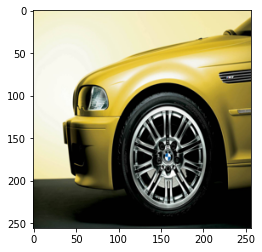

In [3]:
# define pretreatent method
image_size = (224, 224) 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])
#read ,pad and reshape the image and make mask core
#################################################################
##############change the img path and label index################
image_path = 'wheel.jpg'##
v_k ={"snake.jpg":63,"fish.jpg":393,"wheel.jpg":479,"cat.jpg":282,"dog.jpg":207}
label_num=v_k[image_path]##
#################################################################
#################################################################
# [index=63]Indian cobra, Naja naja 
# index=393]anemone fish
# [index=479]car wheel
# [index=282]tiger cat
# [index=207]golden retriever
real = np.array(Image.open(image_path).resize((256,256)))
img_pad = np.pad(real,((56,56),(56,56),(0,0)),'constant',constant_values=(0,0))
mask_core = np.array([0]*12288).reshape((64,64,3))
# model
device = torch.device('cuda:0')
vgg16 = models.vgg16(pretrained=True,progress=True).to(device)
softmax=torch.nn.Softmax(dim=1)

#index
SYNSET_FILE='1000.txt'
synset=open(SYNSET_FILE).read().split('\n')
record = np.zeros((38,38),dtype=np.float32)
plt.imshow(real)
plt.savefig('./occlud_output/real')
plt.show()

In [4]:
def get_occ(mask_core=mask_core,label_num=label_num,img_pad=img_pad):
    for h in range(38):# start at top left corner
        for w in range(38):
            mask = np.pad(mask_core,((w*8,304-w*8),(h*8,304-h*8),(0,0)),'constant',constant_values=(1,1))
            new = img_pad*mask
            pre = image_transform(Image.fromarray(np.uint8(new[56:-56,56:-56,:]))).unsqueeze(0).to(device)
            vgg16.eval()
            with torch.no_grad():
                out=softmax(vgg16(pre)).cpu().numpy()[0]
#             top=np.sort(out)[:-2:-1]
#             topidx=np.argsort(out)[:-2:-1]
                record[w][h]=out[label_num]
    plt.imshow(record,cmap=plt.cm.hot)
    plt.savefig("./occlud_output/occ.jpg")
    return record

In [5]:
def save_occ(record=record):
    record=cv2.resize(record, (256, 256))
    record_out =record.copy()
    plt.imshow(record,cmap=plt.cm.hot)
    plt.savefig("./occlud_output/occ_.jpg")
    record=record[np.newaxis,...]
    record=record[np.newaxis,...]
    record=torch.from_numpy(record)
    return record,record_out

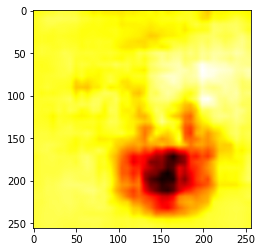

In [6]:
show_img,apply_img=save_occ(get_occ())

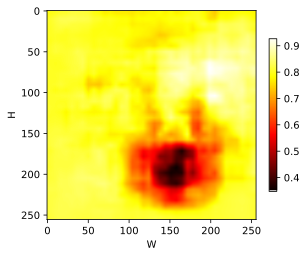

In [7]:
show_heatmaps(show_img,xlabel='W', ylabel='H')

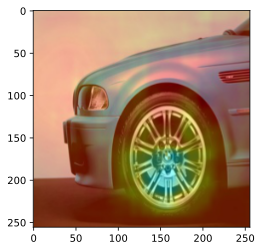

In [8]:
heatmap = cv2.applyColorMap(np.uint8(255 * apply_img), cv2.COLORMAP_JET)
img = 0.4 * heatmap + 0.6*np.float32(real)
cv2.imwrite("./occlud_output/img.jpg", img)
plt.imshow(np.array(Image.open('./occlud_output/img.jpg')))
plt.show()